### Analyses of wheel movements at profficiency
Jun2023 \
author: Inês Laranjeira

In [7]:
"""
IMPORTS
"""
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import os
from mpl_toolkits.mplot3d import Axes3D

from brainbox.task.trials import find_trial_ids
from brainbox.behavior.training import get_sessions, get_training_status
from brainbox.io.one import load_wheel_reaction_times
import brainbox.behavior.wheel as wh
from ibllib.io.extractors.ephys_fpga import extract_wheel_moves
from ibllib.io.extractors.training_wheel import extract_first_movement_times
from one.api import ONE

one = ONE()

# Get my functions
functions_path = "../Functions/"
os.chdir(functions_path)
from one_functions_generic import query_subjects_interest, subjects_interest_data, prepro, timeseries_PSTH

## Get training data

In [8]:
# Get subjects of interest
subjects_of_interest = query_subjects_interest(protocol='ephys', ibl_project='ibl_neuropixel_brainwide_01')
#data = subjects_interest_data(subjects_of_interest)
data = subjects_interest_data(['ibl_witten_32'], phase='proficient', protocol='ephys')

In [25]:
subjects_interest = query_subjects_interest(protocol='training', ibl_project='ibl_neuropixel_brainwide_01')
subjects_interest

array(['437', '438', '6725', '6814', 'CSHL034', 'CSHL045', 'CSHL046',
       'CSHL047', 'CSHL049', 'CSHL051', 'CSHL052', 'CSHL053', 'CSHL054',
       'CSHL055', 'CSHL056', 'CSHL057', 'CSHL058', 'CSHL059', 'CSHL060',
       'CSHL_001', 'CSHL_002', 'CSHL_003', 'CSHL_004', 'CSHL_005',
       'CSHL_006', 'CSHL_007', 'CSHL_008', 'CSHL_009', 'CSHL_010',
       'CSHL_011', 'CSHL_012', 'CSHL_013', 'CSHL_014', 'CSHL_015',
       'CSH_ZAD_001', 'CSH_ZAD_002', 'CSH_ZAD_003', 'CSH_ZAD_004',
       'CSH_ZAD_005', 'CSH_ZAD_006', 'CSH_ZAD_007', 'CSH_ZAD_009',
       'CSH_ZAD_010', 'CSH_ZAD_015', 'CSH_ZAD_016', 'CSH_ZAD_017',
       'CSH_ZAD_018', 'CSH_ZAD_019', 'CSH_ZAD_021', 'CSH_ZAD_022',
       'CSH_ZAD_023', 'CSH_ZAD_024', 'CSH_ZAD_025', 'CSH_ZAD_026',
       'CSH_ZAD_027', 'CSH_ZAD_028', 'CSH_ZAD_029', 'CSH_ZAD_030',
       'CSH_ZAD_031', 'CSH_ZAD_032', 'CSK-IBL-003', 'CSK-IBL-005',
       'DY_001', 'DY_002', 'DY_003', 'DY_005', 'DY_006', 'DY_007',
       'DY_008', 'DY_009', 'DY_010', 'DY_011', 

In [60]:
data = subjects_interest_data(['KS046'], phase='learning', protocol='training')
new_data = prepro(data)

In [61]:
perf = pd.DataFrame(new_data.groupby(['subject_nickname', 'session_start_time', 'session'])['correct_easy'].mean())
perf = perf.reset_index(level=[0, 1, 2])

<AxesSubplot: xlabel='session_start_time', ylabel='correct_easy'>

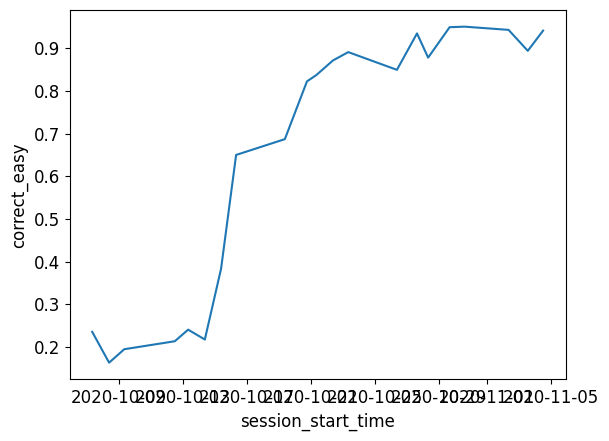

In [63]:
sns.lineplot(x='session_start_time', y='correct_easy', data=perf)

## Plot wheel movements

In [9]:
t_init = 1  # time to plot before stimulus onset
t_end = 1.5 # time to plot after stimulus onset
interval_length = int((t_end + t_init) * 1000)

### Plot per stimulus side 

In [10]:
threshold_deg = 35
gain = 4
threshold_rad = wh.cm_to_rad(1e-1) * (threshold_deg / gain)

### Proficient session

/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:496: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trials['contrastLeft'] = trials['contrastLeft'].fillna(0)
/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:497: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trials['contrastRight'] = trials['contrastRight'].fillna(0)
/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:498: Se

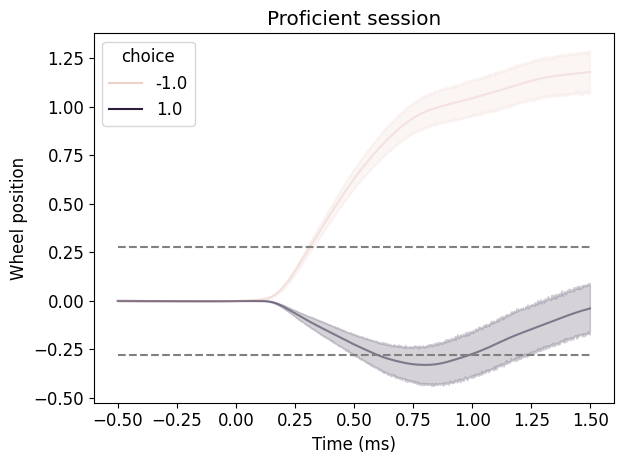

In [11]:
one = ONE()

sessions = ['d23a44ef-1402-4ed7-97f5-47e9a7a504d9']
#sessions = ['cb2ad999-a6cb-42ff-bf71-1774c57e5308']
#sessions = ['288bfbf3-3700-4abe-b6e4-130b5c541e61']
t_init = 0.5
t_end = 1.5
event = 'stimOn_times'

for s, session in enumerate(sessions):
    
    # Trials data
    data = one.load_object(session, obj='trials', namespace='ibl')
    data = data.to_df()

    wheel = one.load_object(session, 'wheel', collection='alf')
    #trials_data = data.loc[data['session']==session][0:50]
    processed_data = prepro(data[0:50])
    processed_data = prepro(data)

    # Get wheel data for that session
    pos, time = wh.interpolate_position(wheel.timestamps, wheel.position)
    

    wheel_df = timeseries_PSTH(time, pos, data, event, t_init, t_end, subtract_baseline=True)
    wheel_df['side'] = wheel_df['choice'] * wheel_df['feedback']
    plt.rc('font', size=12)

    plot_data = wheel_df.loc[wheel_df['choice'].isin([-1, 1])]
    sns.lineplot(x='variable', y='value', hue='choice', data=plot_data, alpha=.5)
    plt.xlabel('Time (ms)')
    plt.ylabel('Wheel position')
    plt.hlines(0.28, -t_init, t_end, color='grey', linestyles='dashed')
    plt.hlines(-0.28, -t_init, t_end, color='grey', linestyles='dashed')

    #plt.ylim([-.4, .4])
    plt.title('Proficient session')
    #plt.hlines(0.28, 9, 2500, color='grey', linestyles='dashed')
    #plt.hlines(-0.28, 9, 2500, color='grey', linestyles='dashed')
    plt.tight_layout()
    plt.show()

### Naif session

/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab/Subjects/CSHL049/2019-11-04/001/alf/_ibl_wheel.timestamps.npy: 100%|██████████| 1.64M/1.64M [00:01<00:00, 1.21MB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab/Subjects/CSHL049/2019-11-04/001/alf/_ibl_wheel.position.npy: 100%|██████████| 1.64M/1.64M [00:00<00:00, 1.99MB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab/Subjects/CSHL049/2019-11-04/001/alf/_ibl_wheelMoves.peakAmplitude.npy: 100%|██████████| 5.22k/5.22k [00:00<00:00, 15.7kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab/Subjects/CSHL049/2019-11-04/001/alf/_ibl_wheelMoves.intervals.npy: 100%|██████████| 10.3k/10.3k [00:00<00:00, 31.2kB/s]


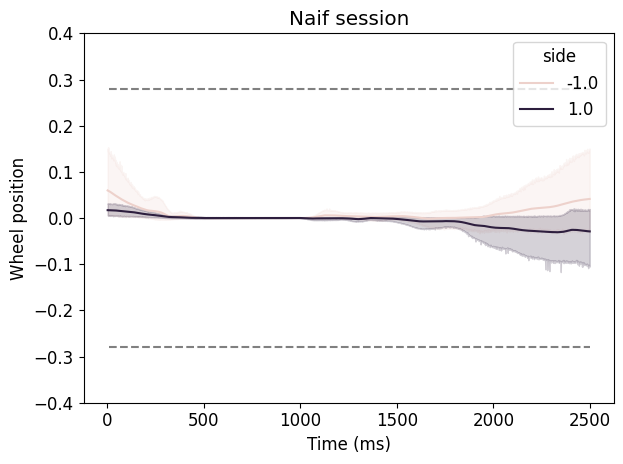

In [59]:
sessions = ['72cb7d25-8b9a-4c48-a57c-b1fcb1307010']  # naif session
sessions = ['7331502c-ac8b-4d1c-ae35-b384e95088f4']
all_wheel = wheel_interval(t_init, t_end, interval_length, sessions)
melted = pd.melt(all_wheel, id_vars=['feedback', 'choice', 'contrast', 'side'], value_vars=np.array(all_wheel.keys()[1:-4]))

plt.rc('font', size=12)

sns.lineplot(x='variable', y='value', hue='side', data=melted)
plt.xlabel('Time (ms)')
plt.ylabel('Wheel position')
plt.ylim([-.4, .4])
plt.title('Naif session')
plt.hlines(0.28, 9, 2500, color='grey', linestyles='dashed')
plt.hlines(-0.28, 9, 2500, color='grey', linestyles='dashed')

plt.tight_layout()

### Plot per contrast, choice, and feedback

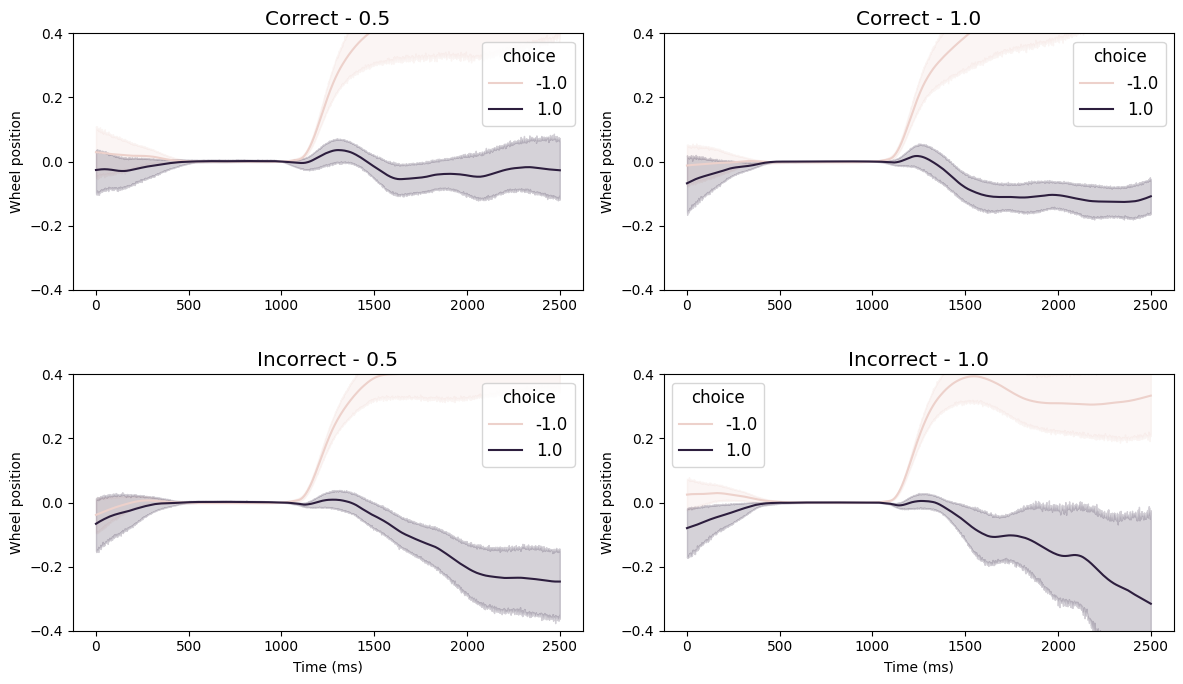

In [13]:
contrasts = melted.contrast.unique()
contrasts.sort()

fig, ax = plt.subplots(nrows=2, ncols=len(contrasts), sharex=False, sharey=False, figsize=[12, 7])

plt.rc('font', size=12)

for c, contrast in enumerate(contrasts):
    
    data_correct = melted.loc[(melted['contrast']==contrast) & (melted['feedback']==1.0)]
    data_incorrect = melted.loc[(melted['contrast']==contrast) & (melted['feedback']==0.0)]

    sns.lineplot(x='variable', y='value', hue='choice', data=data_correct, ax = ax[0, c])
    sns.lineplot(x='variable', y='value', hue='choice', data=data_incorrect, ax = ax[1, c])

    ax[0,c].set_xlabel(' ')
    ax[1,c].set_xlabel('Time (ms)')
    ax[0,c].set_ylabel('Wheel position')
    ax[1,c].set_ylabel('Wheel position')
    ax[0, c].set_ylim([-.4, .4])
    ax[1, c].set_ylim([-.4, .4])

    ax[0,c].set_title(str('Correct - ' + str(contrast)))
    ax[1,c].set_title(str('Incorrect - ' + str(contrast)))

plt.tight_layout()